<a href="https://colab.research.google.com/github/KeunhoLee/gan_thumbnail/blob/main/DCGAN_1st.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf

In [12]:
tf.keras.backend.clear_session()

In [13]:
tf.__version__

'2.4.1'

In [14]:
import os.path
import numpy as np
from keras.models import * 
from keras.layers import * 
from keras.optimizers import * 
import keras.backend as K 
import matplotlib.pyplot as plt

import os 
from PIL import Image


In [15]:
K.set_image_data_format('channels_last')

In [16]:
class Gan: 
  def __init__(self, img_data): 
    img_size = img_data.shape[1]
    img_size_2 = img_data.shape[2]
    channel = img_data.shape[3] if len(img_data.shape) >= 4 else 1 
    self.img_data = img_data 
    self.input_shape = (img_size, img_size_2, channel) 
    self.img_rows = img_size 
    self.img_cols = img_size_2 
    self.channel = channel 
    self.noise_size = 100 
    
    # Create D and G. 
    self.create_d() 
    self.create_g() 
    
    # Build model to train D. 
    optimizer = Adam(lr=0.0008) 
    self.D.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # Build model to train G. 
    optimizer = Adam(lr=0.0004) 
    self.D.trainable = False
    self.AM = Sequential() 
    self.AM.add(self.G) 
    self.AM.add(self.D) 
    self.AM.compile(loss='binary_crossentropy', optimizer=optimizer)

  def create_d(self):
    self.D = Sequential()
    depth = 64
    dropout = 0.4 
    self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=self.input_shape, padding='same')) 
    self.D.add(LeakyReLU(alpha=0.2)) 
    self.D.add(Dropout(dropout)) 
    self.D.add(Conv2D(depth*2, 5, strides=2, padding='same')) 
    self.D.add(LeakyReLU(alpha=0.2)) 
    self.D.add(Dropout(dropout)) 
    self.D.add(Conv2D(depth*4, 5, strides=2, padding='same')) 
    self.D.add(LeakyReLU(alpha=0.2)) 
    self.D.add(Dropout(dropout)) 
    self.D.add(Conv2D(depth*8, 5, strides=1, padding='same')) 
    self.D.add(LeakyReLU(alpha=0.2)) 
    self.D.add(Dropout(dropout)) 
    self.D.add(Flatten()) 
    self.D.add(Dense(1)) 
    self.D.add(Activation('sigmoid')) 
    self.D.summary() 
    return self.D

  def create_g(self):
    self.G = Sequential()
    dropout = 0.4
    depth = 64+64+64+64
    dim = 8 
    self.G.add(Dense(dim*dim*depth, input_dim=self.noise_size)) 
    self.G.add(BatchNormalization(momentum=0.9)) 
    self.G.add(Activation('relu')) 
    self.G.add(Reshape((dim, dim, depth))) 
    self.G.add(Dropout(dropout)) 
    self.G.add(UpSampling2D()) 
    self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same')) 
    self.G.add(BatchNormalization(momentum=0.9)) 
    self.G.add(Activation('relu')) 
    self.G.add(UpSampling2D()) 
    self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same')) 
    self.G.add(BatchNormalization(momentum=0.9)) 
    self.G.add(Activation('relu')) 
    self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same')) 
    self.G.add(BatchNormalization(momentum=0.9)) 
    self.G.add(Activation('relu')) 
    self.G.add(Conv2DTranspose(self.channel, 5, padding='same')) 
    self.G.add(Activation('sigmoid')) 
    self.G.summary() 
    return self.G
  
  def train(self, batch_size=100):   
    # Pick image data randomly. 
    
    images_train = self.img_data[np.random.randint(0, self.img_data.shape[0], size=batch_size), :, :, :] 
    
    # Generate images from noise. 
    
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size]) 
    images_fake = self.G.predict(noise) 
    
    # Train D. 
    x = np.concatenate((images_train, images_fake)) 
    y = np.ones([2*batch_size, 1]) 
    y[batch_size:, :] = 0 
    self.D.trainable = True 
    d_loss = self.D.train_on_batch(x, y) 
    
    # Train G. 
    y = np.ones([batch_size, 1]) 
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.noise_size]) 
    self.D.trainable = False 
    a_loss = self.AM.train_on_batch(noise, y) 
    
    return d_loss, a_loss, images_fake

  def predict(self, noise):
    return self.G.predict(noise)

  def save(self):
    self.G.save_weights('/content/gdrive/MyDrive/saap_pjt_1_thumbnail/weights/gan_g_weights.h5') 
    self.D.save_weights('/content/gdrive/MyDrive/saap_pjt_1_thumbnail/weights/gan_d_weights.h5')

  def load(self):
    if os.path.isfile('/content/gdrive/MyDrive/saap_pjt_1_thumbnail/weights/gan_g_weights.h5'):
      self.G.load_weights('/content/gdrive/MyDrive/saap_pjt_1_thumbnail/weights/gan_g_weights.h5') 
      print("Load G from file.") 

    if os.path.isfile('gan_d_weights.h5'): 
      self.D.load_weights('gan_d_weights.h5') 
      print("Load D from file.")

class NaverData(): 
  def __init__(self): 
    img_data_list = [] 
    err_cnt1=0
    err_cnt2=0
    images = os.listdir("/content/gdrive/MyDrive/saap_pjt_1_thumbnail/thumbnails_resize") #naver_id_" + str(id) + ".jpg
    for i, path in enumerate(images): 

      title, ext = os.path.splitext(path)
      if ext not in ['.jpg']:
        continue
      
      try:
        img = Image.open("/content/gdrive/MyDrive/saap_pjt_1_thumbnail/thumbnails_resize/" + path) 
      except:
        err_cnt1+=1
       
      if np.array(img).shape != (32,32,3):
        err_cnt2 += 1
        continue
      
      img_data_list.append([np.array(img).astype('float32')]) 
      # print(np.array(img).shape)
      
    try:
      self.x_train = np.vstack(img_data_list) / 255.0 
    except ValueError as e:
      err_cnt2 += 1 
      print(path + " Error : ", e)
    # print(self.x_train.shape)
    print(err_cnt1, "error occured.")
    print(err_cnt2, "error occured.")


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# import os 
# from PIL import Image 
# images = os.listdir("/content/gdrive/MyDrive/saap_pjt_1_thumbnail/thumbnails") 
# err_cnt = 0

# for i, name in enumerate(images): 
#   # print(i)
#   try:
#     img = Image.open("/content/gdrive/MyDrive/saap_pjt_1_thumbnail/thumbnails/" + name)
#     img_resize = img.resize((32, 32), Image.ANTIALIAS)
#     img_resize.save(f'/content/gdrive/MyDrive/saap_pjt_1_thumbnail/thumbnails_resize/naver_id_{i}.jpg')
#   except:
#     err_cnt += 1

In [17]:
dataset = NaverData()

47 error occured.
4 error occured.


In [18]:
# Load dataset.
# dataset = PokemonData() 
x_train = dataset.x_train 

import pickle

with open('/content/gdrive/MyDrive/saap_pjt_1_thumbnail/data_32_32.pickle', 'wb') as f:
    pickle.dump(x_train, f, pickle.HIGHEST_PROTOCOL)

In [19]:
x_train.shape

(1256, 32, 32, 3)

In [32]:
# Init network 

gan = Gan(x_train) 
# gan.load()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 256)        

Epoch: 0, D Loss: 0.6185259247819582, AM Loss: 0.37910956010455266
Epoch: 20, D Loss: 0.14753673039376736, AM Loss: 3.608571211496989
Epoch: 40, D Loss: 0.4525166427095731, AM Loss: 1.2621611058712006
Epoch: 60, D Loss: 0.14185516287883124, AM Loss: 2.2838765382766724
Epoch: 80, D Loss: 0.34462376683950424, AM Loss: 2.1077106297016144
Epoch: 100, D Loss: 0.544980525970459, AM Loss: 1.771423598130544
Epoch: 120, D Loss: 0.20624537207186222, AM Loss: 4.255620022614797
Epoch: 140, D Loss: 0.20967140545447668, AM Loss: 3.400459965070089
Epoch: 160, D Loss: 0.3978341569503148, AM Loss: 3.1416416565577188
Epoch: 180, D Loss: 0.5521397950748602, AM Loss: 5.788524687290192
Epoch: 200, D Loss: 0.4248397486905257, AM Loss: 3.3248048424720764
Epoch: 220, D Loss: 0.23265779142578444, AM Loss: 3.4778252243995667
Epoch: 240, D Loss: 0.4895612448453903, AM Loss: 1.8292966236670811
Epoch: 260, D Loss: 0.16735932293037573, AM Loss: 4.873481810092926
Epoch: 280, D Loss: 0.3052764895061652, AM Loss: 3.37

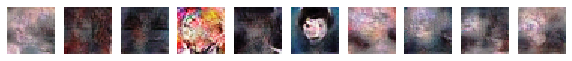

In [33]:
# Some parameters. 
epochs = 5000
sample_size = 10 
batch_size = 100
train_per_epoch = x_train.shape[0] // batch_size
gen_imgs = {}

for epoch in range(0, epochs): 
  total_d_loss = 0.0 
  total_a_loss = 0.0 
  imgs = None 
  
  for batch in range(0, train_per_epoch): 
    d_loss, a_loss, t_imgs = gan.train(batch_size) 
    total_d_loss += d_loss 
    total_a_loss += a_loss 
    
    if imgs is None:
      imgs = t_imgs
  

  if epoch % 20 == 0 or epoch == epochs - 1: 
    total_d_loss /= train_per_epoch 
    total_a_loss /= train_per_epoch 
    gen_imgs[epoch] = imgs
    print("Epoch: {}, D Loss: {}, AM Loss: {}" .format(epoch, total_d_loss, total_a_loss))

# Show generated images. 

fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1)) 
for i in range(0, sample_size): 
  ax[i].set_axis_off() 
  ax[i].imshow(imgs[i].reshape((gan.img_rows, gan.img_cols, gan.channel)), interpolation='nearest'); 
plt.show() 
plt.close(fig); 
  
# Save weights 
# gan.save()

In [ ]:
gan.G.save_weights("./gan_g_weights.h5")

In [ ]:
gan.D.save_weights("./gan_d_weights.h5")

In [ ]:
! cp gan_d_weights.h5 ./gdrive/MyDrive/saap_pjt_1_thumbnail/weights/
! cp gan_g_weights.h5 ./gdrive/MyDrive/saap_pjt_1_thumbnail/weights/

In [38]:
with open('./gen_images_3232.pickle', 'wb') as f:
    pickle.dump(gen_imgs, f, pickle.HIGHEST_PROTOCOL)

In [41]:
! cp gen_images_3232.pickle ./gdrive/MyDrive/saap_pjt_1_thumbnail/weights/

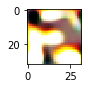

In [28]:
fake_img = gan.predict(np.random.uniform(-0.4, -0.5, size=[1, 100]) )

fig, ax = plt.subplots(1, 1, figsize=(1, 1)) 
ax.imshow(fake_img.reshape((gan.img_rows, gan.img_cols, gan.channel)), interpolation='nearest'); 
plt.show()
plt.close(fig); 

In [40]:
len(gen_imgs)

251